# Machine Learning for metabolomes of microbial communities

In [1]:
# imports
import sys
sys.path.append( '..' )

from helpers import *
from FIA import *
from ML4com import *
from DL4com import *
from VAE.vae import *

import warnings
warnings.simplefilter(action='ignore', category=sklearn.exceptions.UndefinedMetricWarning)

## Loading in

In [2]:
orig_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/data/Com8_grown_together"))
data_dir  = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/FIA/Com8_grown_together"))

strains = pd.read_csv( os.path.join(orig_dir, "strains.tsv"), sep="\t")
comm = pd.read_csv( os.path.join(orig_dir, "comb_one_hot.tsv"), sep="\t")
metData = pd.read_csv( os.path.join(orig_dir, "metData.tsv"), sep="\t")
metData.index = pd.read_csv( os.path.join(orig_dir, "metName.tsv"), sep="\t")

ys = comm
targets = strains["Organism"].values

### Latent space data

In [ ]:
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/ML/latent"))

verbosity = 1
backend_name = "tensorflow"
computation = "cpu"
name = "mae_cos"
project = f"vae_{backend_name}_{computation}_{name}"
outdir = Path( os.path.normpath( os.path.join(run_dir, project)) )
if not os.path.isdir(outdir):
    os.mkdir(outdir)


# X = pd.read_csv(f"/mnt/d/runs/VAE/results/encoded_mu_{name}.tsv", index_col=["Unnamed: 0"], sep="\t")

### Annotated data

In [ ]:
run_dir = os.path.normpath(os.path.join(os.getcwd(), "/mnt/d/runs/ML/annot"))
name = "annotated"

met_raw_pos = pd.read_excel( os.path.join(orig_dir,"FIA-Data Com8_20230717_P0024_msAV206-312.xlsx"), sheet_name="pos" )
met_raw_neg = pd.read_excel( os.path.join(orig_dir,"FIA-Data Com8_20230717_P0024_msAV206-312.xlsx"), sheet_name="neg" )
met_raw_comb = pd.concat( [total_ion_count_normalization( join_df_metNames(met_raw_pos) ),
                           total_ion_count_normalization( join_df_metNames(met_raw_neg) )] )

outdir = Path( os.path.normpath( run_dir ) )

X = met_raw_comb.transpose()

## Learning and tuning

In [3]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
classifier = KNeighborsClassifier
algorithm_name = "Kneighbours classifier"

configuration_space = ConfigurationSpace()
hyperparameters = [ 
                    Constant("random_state", 42),
                    Constant("n_neighbors",   2),
                    Categorical("weights",    ["uniform", "distance"], default="uniform"),
                    Integer("leaf_size",      (10, 100), log=True, default=30),
                    Integer("p",              (1, 2), default=2),
                    Constant("metric",        "minkowski")
                  ]
configuration_space.add_hyperparameters([hyperparameters])

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

plot_metrics_df(metrics_df, organism_metrics_df, overall_metrics_df, algorithm_name, outdir)

### Support-Vector Machine

In [ ]:
from sklearn.svm import SVC 
classifier = SVC
algorithm_name = "Support-vector classifier"

configuration_space = ConfigurationSpace()
hyperparameters = [ 
                    Constant("random_state", 42),
                    Float("C",              (0.5, 2.0), default=1.0),
                    Categorical("kernel",   ["linear", "poly", "rbf", "sigmoid", "precomputed"], default="rbf"),
                    Integer("degree"        (2,4), default=3),
                    Categorical("gamma",    ["scale", "auto"]),
                    Float("coef0",          (0.0, 1.0), log=True, default=0.0),
                    Integer("leaf_size",    (10, 100), log=True, default=30),
                    Integer("p",            (1, 2), default=2),
                    Constant("metric",      "minkowski")
                  ]
conditions = [
                InCondition(hyperparameters[2], hyperparameters[1], ["poly"]),
                InCondition(hyperparameters[4], hyperparameters[1], ["poly", "sigmoid"]),
                InCondition(hyperparameters[3], hyperparameters[1], ["rbf", "poly", "sigmoid"])
             ]

configuration_space.add_hyperparameters([hyperparameters])
configuration_space.add_conditions(conditions)

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

plot_metrics_df(metrics_df, organism_metrics_df, overall_metrics_df, algorithm_name, outdir)

### Gaussian Process Classifier

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
classifier = GaussianProcessClassifier
algorithm_name = "Gaussian process classifier"


configuration_space = ConfigurationSpace()
hyperparameters = [ 
                    Constant("random_state", 42),
                    Integer("max_iter_predict",   (10, 1000), log=True, default=100),
                  ]
configuration_space.add_hyperparameters([hyperparameters])

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

plot_metrics_df(metrics_df, organism_metrics_df, overall_metrics_df, algorithm_name, outdir)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB
algorithm_name = "Gaussian Naive-Bayes"

configuration_space = ConfigurationSpace()
hyperparameters = [ 
                    Constant("var_smoothing",   1e-9),
                  ]
configuration_space.add_hyperparameters([hyperparameters])

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

plot_metrics_df(metrics_df, organism_metrics_df, overall_metrics_df, algorithm_name, outdir)

In [ ]:
from sklearn.naive_bayes import ComplementNB
classifier = ComplementNB
algorithm_name = "Complement Naive-Bayes"

configuration_space = ConfigurationSpace()
hyperparameters = [ 
                    Float("alpha",   (0.0, 1.0), log=True, default=1.0),
                  ]
configuration_space.add_hyperparameters([hyperparameters])

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

plot_metrics_df(metrics_df, organism_metrics_df, overall_metrics_df, algorithm_name, outdir)

### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier
algorithm_name = "decision tree"

configuration_space = ConfigurationSpace()
ccp_alpha   = Float("ccp_alpha", (1e-3, 1e0), log=True, default=0.01)
configuration_space.add_hyperparameters([ccp_alpha])

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

plot_metrics_df(metrics_df, organism_metrics_df, overall_metrics_df, algorithm_name, outdir)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 10 to 2 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 2 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config 8f03e1 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


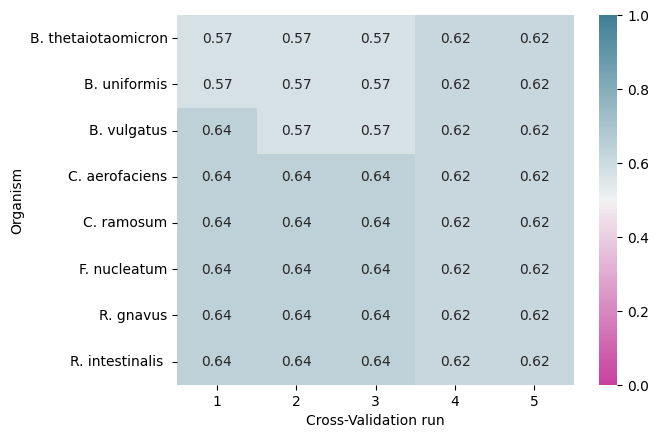

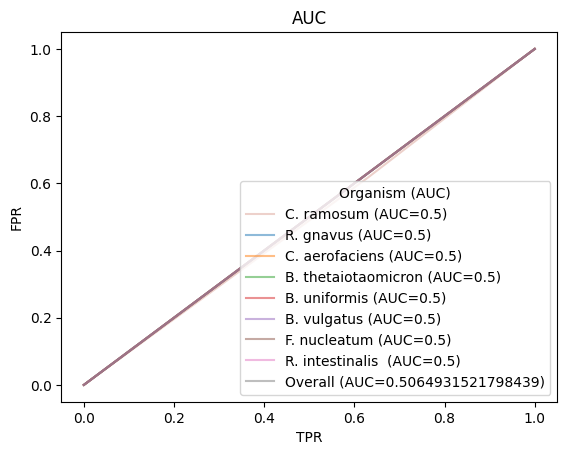

## Random Forest

### Standard

In [ ]:
from sklearn.ensemble import RandomForestClassifier

configuration_space = ConfigurationSpace()
ccp_alpha       = Float("ccp_alpha", (1e-3, 1e-1), log=True, default=0.01)
n_estimators    = Integer("n_estimators", (10,1000), log=True, default=100)
max_depth       = Integer("max_depth", (5, 100), default=20)
configuration_space.add_hyperparameters([ccp_alpha, n_estimators, max_depth])

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config fe7927 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:319] Finished 100 trials.
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:319] Finished 200 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


### Gradient Boosting

##### Extreme Gradiant Boosting

In [ ]:
from xgboost import XGBClassifier

configuration_space = ConfigurationSpace()
objective           = Constant( "objective",            "binary:logistic")
num_parallel_tree   = Constant( "num_parallel_tree",    4)
n_estimators        = Integer(  "n_estimators",         (10,1000), log=True, default=100)
max_depth           = Integer(  "max_depth",            (1, 100), default=20)
subsample           = Float(    "subsample",            (1e-1, 1e0), default=1e0)
learning_rate       = Float(    "learning_rate",        (1e-2, 5e-1), default=1e-1)
configuration_space.add_hyperparameters([objective, num_parallel_tree, n_estimators, max_depth, subsample, learning_rate])

incumbent = tune_classifier(X, ys, classifier, configuration_space, 200, name, algorithm_name, outdir, verbosity)

metrics_df, organism_metrics_df, overall_metrics_df = cross_validate_classifier(X, ys, targets, incumbent, classifier, algorithm_name, outdir)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 60 to 50 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 50 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config 829f77 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:319] Finished 100 trials.
[INFO][smbo.py:319] Finished 150 trials.
[INFO][smbo.py:319] Finished 200 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: inf
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


## Analysis

In [ ]:
metrics_df

,Organism,Cross-Validation run,Accuracy,AUC,TPR,FPR,Threshold,Conf_Mat
0,C. ramosum,1,0.642857,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 9]]"
1,C. ramosum,2,0.642857,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 9]]"
2,C. ramosum,3,0.642857,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 9]]"
3,C. ramosum,4,0.615385,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 8]]"
4,C. ramosum,5,0.615385,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 8]]"
5,R. gnavus,1,0.642857,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 9]]"
6,R. gnavus,2,0.642857,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 9]]"
7,R. gnavus,3,0.642857,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 9]]"
8,R. gnavus,4,0.615385,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 8]]"
9,R. gnavus,5,0.615385,0.5,"[0.0, 1.0]","[0.0, 1.0]","[inf, 1.0]","[[0, 5], [0, 8]]"


### DT depiction

In [ ]:
model = DecisionTreeClassifier(random_state=42)

# for i, estimator in enumerate(model.estimators_):
for i, s in enumerate(strains):
    model.fit(latent_space.transpose(),ys.transpose()[i])
    plot_decision_trees(model=model, feature_names=X.index, class_names=["absent", s], outdir=outdir, name=f"decisiontree/tree_{s}{suffix}")

NameError: name 'DecisionTreeClassifier' is not defined

### Feature importance

In [ ]:
feature_importances = {}
for i, s in enumerate(strains["0"]):
    model = XGBClassifier(**best_hp)
    model.fit(X.values, ys[f"{i}"])
    feature_importances[s] = model.feature_importances_

    imp_feat = feature_importances.get(s) > 0.1

    plt.bar(X.columns[imp_feat], feature_importances.get(s)[imp_feat])
    plt.savefig(f"../../reports/ML/XGBoost/important_features_{s}_3_strict.png")
    plt.close()

In [ ]:
feat_imp_df = pd.DataFrame(feature_importances, index=X.columns)
feat_imp_df.to_csv("../../reports/ML/XGBoost/feature_importance_2.tsv", sep="\t")

In [ ]:
feat_imp_df["B. vulgatus"].loc[feat_imp_df["B. vulgatus"].max() == feat_imp_df["B. vulgatus"]]

metNames
Palmitoylethanolamide[M+H]+\n3-Dehydrosphinganine[M+H]+\nSphingosine[M+H]    0.719717
Name: B. vulgatus, dtype: float32

In [ ]:
strains

,0
0,C. ramosum
1,R. gnavus
2,C. aerofaciens
3,B. thetaiotaomicron
4,B. uniformis
5,B. vulgatus
6,F. nucleatum
7,R. intestinalis
